![](../img/330-banner.png)

# Lecture 4: $k$-Nearest Neighbours and SVM RBFs  

UBC 2024-25

> If two things are similar, the thought of one will tend to trigger the thought of the other <br>
-- Aristotle

## Imports, announcements, and LOs

### Imports

In [1]:
import os
import sys

import IPython
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import HTML

sys.path.append(os.path.join(os.path.abspath(".."), "code"))
import ipywidgets as widgets
import mglearn
from IPython.display import display
from ipywidgets import interact, interactive
from plotting_functions import *
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_validate, train_test_split
from utils import *

%matplotlib inline
pd.set_option("display.max_colwidth", 200)
import warnings

warnings.filterwarnings("ignore")
DATA_DIR = "../data/"

## Let's start with a recap

Slides here: https://docs.google.com/presentation/d/1r7ENRHGx5Af97GeNXM0Ix3z_J25lecfOCq4kZB-yeB4/edit?usp=sharing

### Learning outcomes

From this lecture, you will be able to 

- explain the notion of similarity-based algorithms; 
- broadly describe how $k$-NNs use distances; 
- discuss the effect of using a small/large value of the hyperparameter $k$ when using the $k$-NN algorithm; 
- describe the problem of curse of dimensionality; 
- explain the general idea of SVMs with RBF kernel;
- broadly describe the relation of `gamma` and `C` hyperparameters of SVMs with the fundamental tradeoff.

<br><br>

## Motivation and distances [[video](https://youtu.be/hCa3EXEUmQk)]

### General idea of $k$-nearest neighbours algorithm

- Consider the following toy dataset with two classes.
    - blue circles $\rightarrow$ class 0
    - red triangles $\rightarrow$ class 1 
    - green stars $\rightarrow$ test examples

In [2]:
X, y = mglearn.datasets.make_forge()
X_test = np.array([[8.2, 3.66214339], [9.9, 3.2], [11.2, 0.5]])

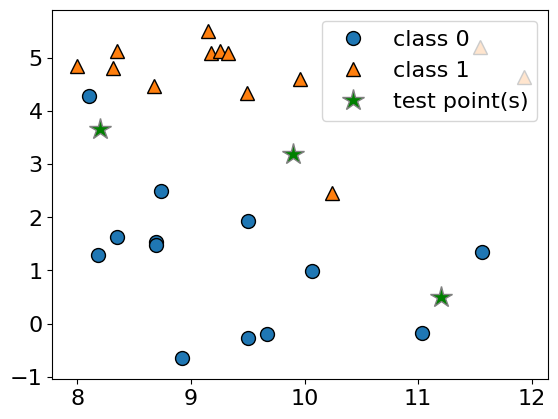

In [3]:
plot_train_test_points(X, y, X_test)

- Given a new data point, predict the class of the data point by finding the "closest" data point in the training set, i.e., by finding its "nearest neighbour" or majority vote of nearest neighbours. 

In [4]:
import matplotlib
import panel as pn
from panel import widgets
from panel.interact import interact

pn.extension()

n_neighbors 1
n_neighbors 10
n_neighbors 9
n_neighbors 8
n_neighbors 7
n_neighbors 6
n_neighbors 5
n_neighbors 4
n_neighbors 3
n_neighbors 2
n_neighbors 1



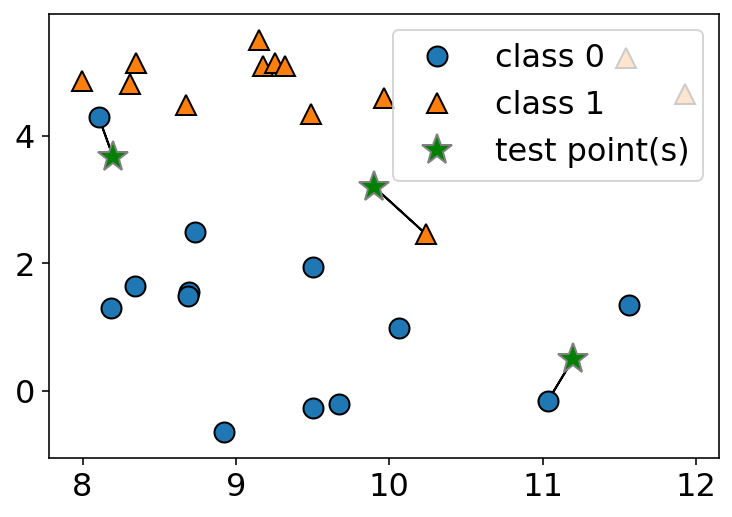
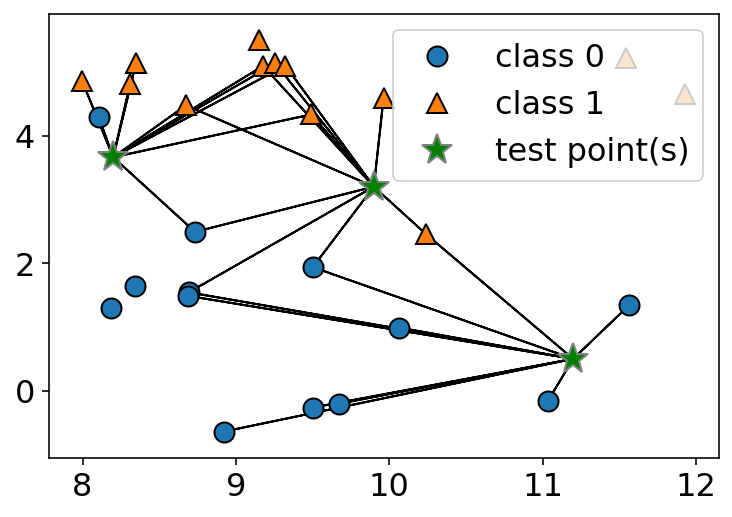
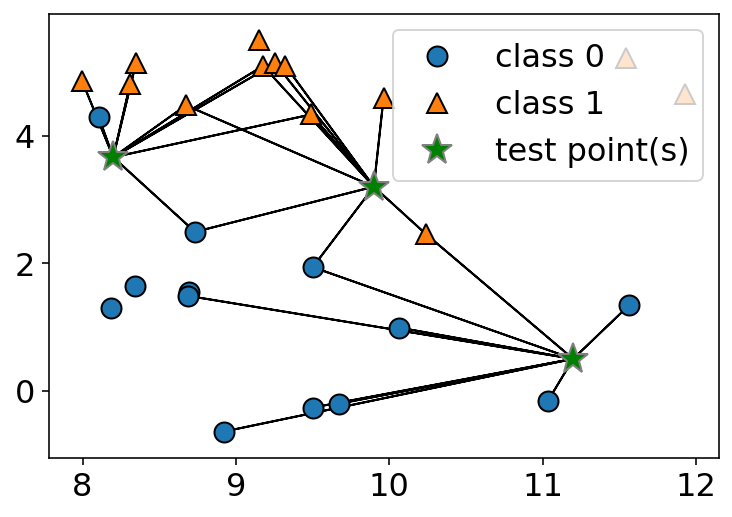
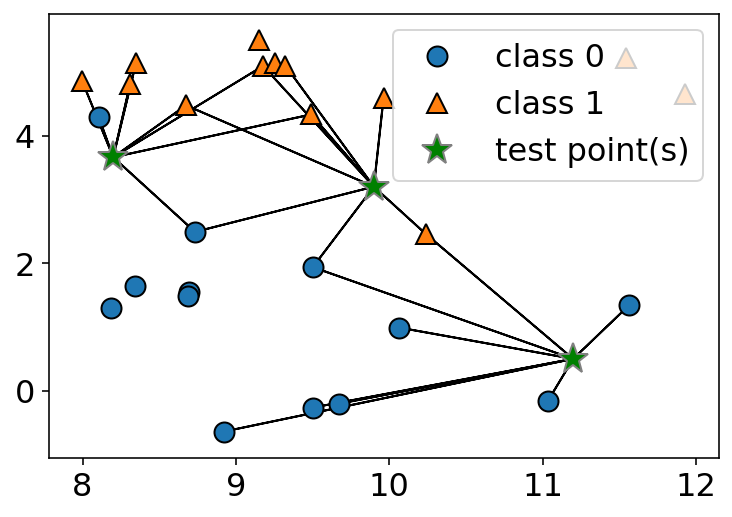
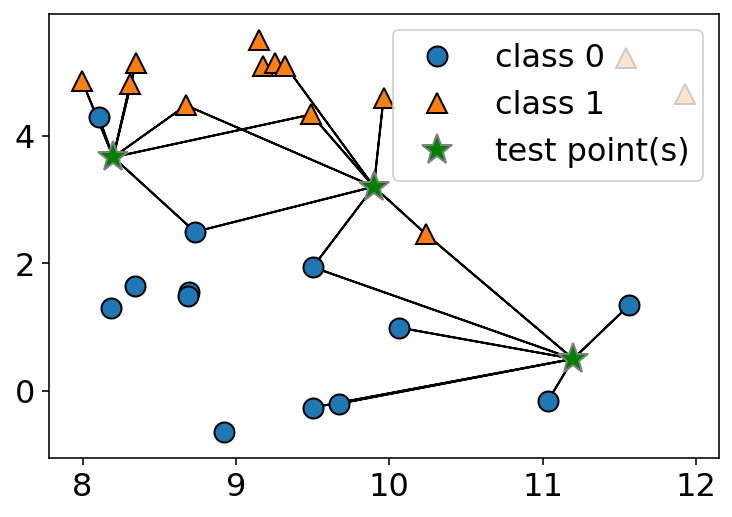
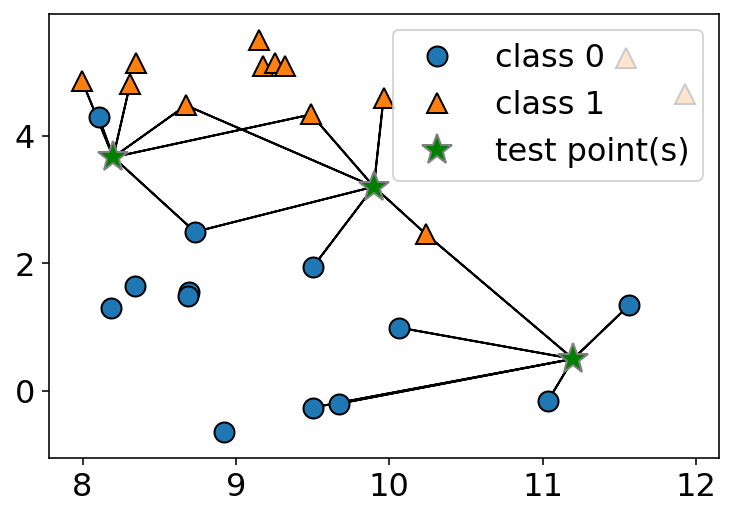
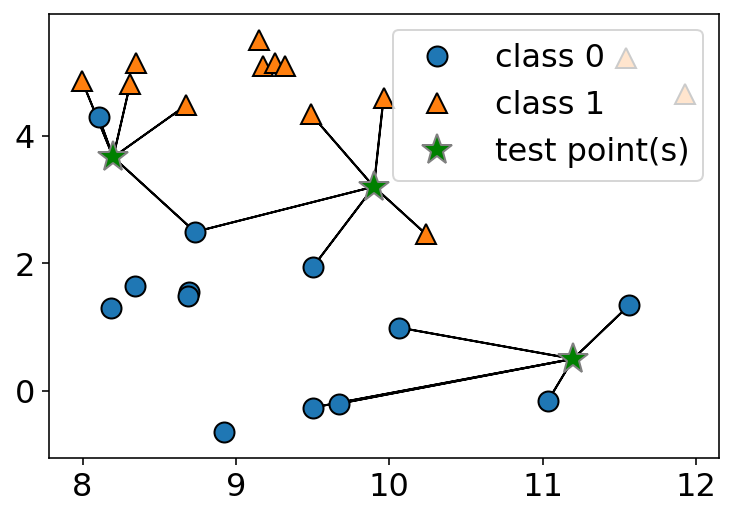
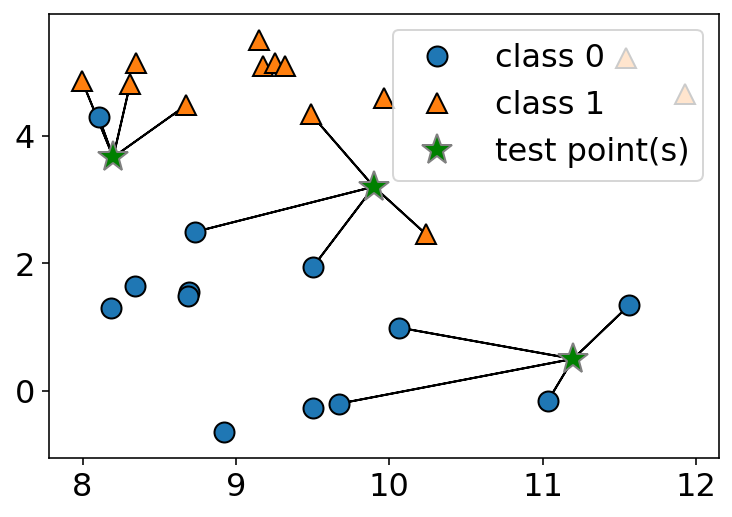
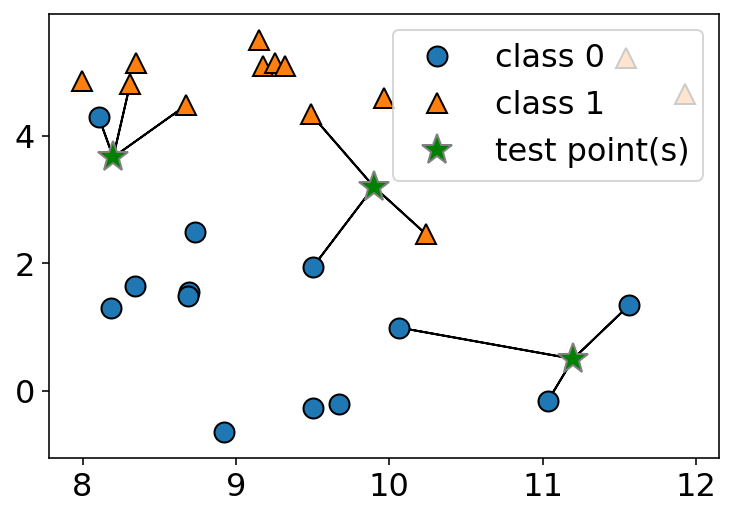
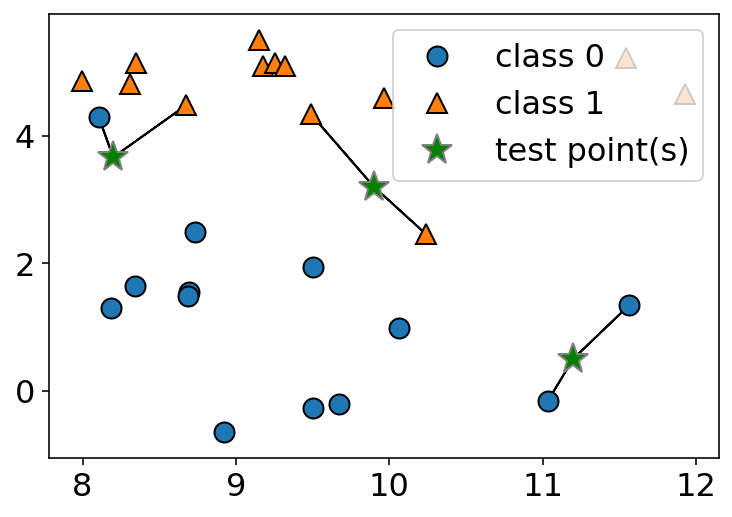
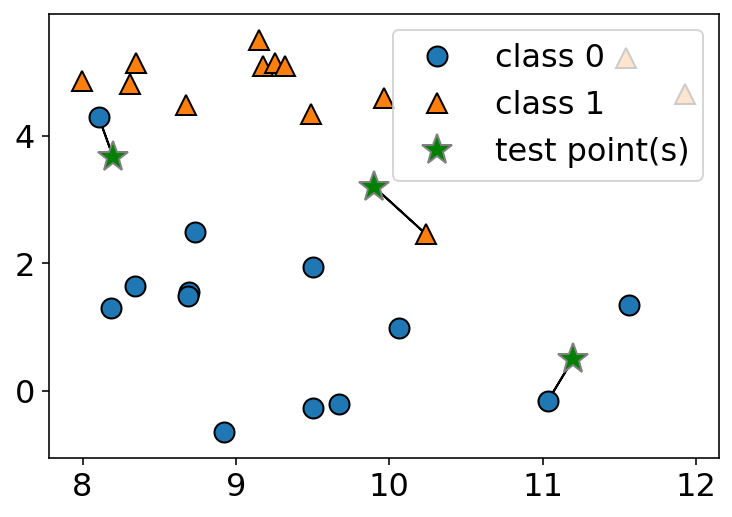

<Figure size 640x480 with 0 Axes>

In [5]:
def f(n_neighbors):
    plt.clf()
    fig = plt.figure(figsize=(6, 4))
    plot_knn_clf(X, y, X_test, n_neighbors=n_neighbors)
    plt.close()
    return pn.pane.Matplotlib(fig, tight=True)


n_neighbors_selector = pn.widgets.IntSlider(
    name="n_neighbors", start=1, end=10, value=1
)
# interact(f, n_neighbors=n_neighbors_selector)
interactive_plot = interact(f, n_neighbors=n_neighbors_selector).embed(max_opts=10)
interactive_plot

### Geometric view of tabular data and dimensions 

- To understand analogy-based algorithms it's useful to think of data as points in a high dimensional space. 
- Our `X` represents the problem in terms of relevant **features** ($d$) with one dimension for each **feature** (column).
- Examples are **points in a $d$-dimensional space**. 

How many dimensions (features) are there in the cities data?

In [6]:
cities_df = pd.read_csv(DATA_DIR + "canada_usa_cities.csv")
X_cities = cities_df[["longitude", "latitude"]]
y_cities = cities_df["country"]

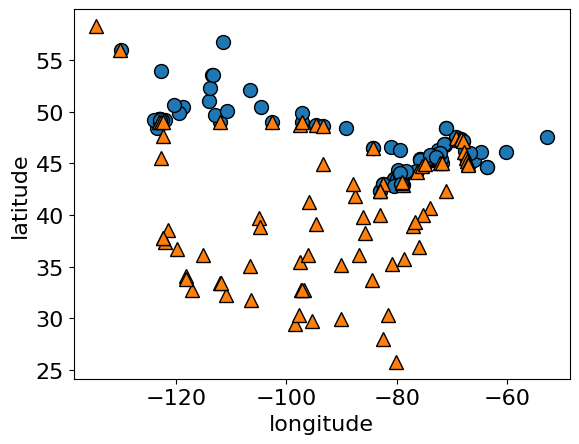

In [7]:
mglearn.discrete_scatter(X_cities.iloc[:, 0], X_cities.iloc[:, 1], y_cities)
plt.xlabel("longitude")
plt.ylabel("latitude");

### Dimensions in ML problems 

In ML, usually we deal with high dimensional problems where examples are hard to visualize.  

- $d \approx 20$ is considered low dimensional
- $d \approx 1000$ is considered medium dimensional 
- $d \approx 100,000$ is considered high dimensional 

All the **features** associated with **an example** form a **feature vector**

### Similarity between examples

Let's take 2 points (two feature vectors) from the cities dataset.

In [8]:
two_cities = X_cities.sample(2, random_state=120)
two_cities

,longitude,latitude
69,-104.8253,38.8340
35,-112.0741,33.4484


The two sampled points are shown as big black circles.

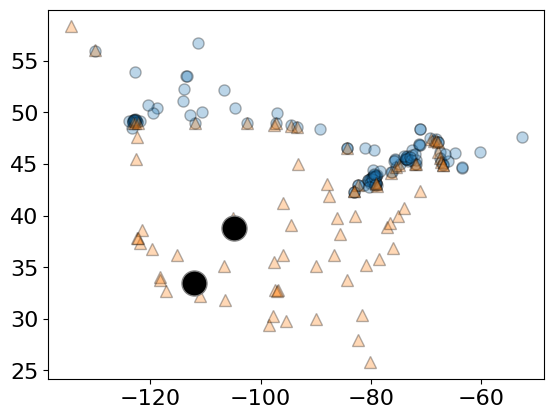

In [9]:
mglearn.discrete_scatter(
    X_cities.iloc[:, 0], X_cities.iloc[:, 1], y_cities, s=8, alpha=0.3
)
mglearn.discrete_scatter(
    two_cities.iloc[:, 0], two_cities.iloc[:, 1], markers="o", c="k", s=18
);

### Distance between feature vectors 

- For the cities at the two big circles (`two_cities`), what is the _distance_ between them?
- A common way to calculate the distance between vectors is calculating the **Euclidean distance**. 
- The Euclidean distance 
  - in one dimension between $u$ and $v$:
  $$distance(u, v) = \sqrt{(u - v)^2} = | u - v |$$

  - in two dimensions between $u = <u_1, u_2>$ and $v = <v_1, v_2>$:
  $$distance(u, v) = \sqrt{(u_1 - v_1)^2 + (u_2 - v_2)^2}$$

  - generally, in higher dimensions between vectors <br>
  $u = <u_1, u_2, \dots, u_n>$ and $v = <v_1, v_2, \dots, v_n>$ is defined as:

$$distance(u, v) = \sqrt{\sum_{i =1}^{n} (u_i - v_i)^2}$$ 


### Euclidean distance 

In [10]:
two_cities

,longitude,latitude
69,-104.8253,38.8340
35,-112.0741,33.4484


In [11]:
# Subtract the two cities
print("Subtract the cities: \n%s\n" % (two_cities.iloc[1] - two_cities.iloc[0]))

# Squared sum of the difference
print(
    "Sum of squares: %0.4f" % (np.sum((two_cities.iloc[1] - two_cities.iloc[0]) ** 2))
)

# Take the square root
print(
    "Euclidean distance between cities: %0.4f"
    % (np.sqrt(np.sum((two_cities.iloc[1] - two_cities.iloc[0]) ** 2)))
)

Subtract the cities: 
longitude   -7.2488
latitude    -5.3856
dtype: float64

Sum of squares: 81.5498
Euclidean distance between cities: 9.0305


In [12]:
two_cities

,longitude,latitude
69,-104.8253,38.8340
35,-112.0741,33.4484


In [13]:
# Euclidean distance using sklearn
from sklearn.metrics.pairwise import euclidean_distances

euclidean_distances(two_cities)

array([[0.        , 9.03049217],
       [9.03049217, 0.        ]])

Note: `scikit-learn` supports a number of other [distance metrics](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html).


### Finding the nearest neighbour

- Let's look at distances from all cities to all other cities

In [14]:
dists = euclidean_distances(X_cities)
np.fill_diagonal(dists, np.inf)
dists.shape

(209, 209)

In [15]:
pd.DataFrame(dists)

,0,1,2,3,4,5,6,7,8,9,...,199,200,201,202,203,204,205,206,207,208
0,inf,4.955113,9.869531,10.106452,10.449666,19.381676,28.366626,33.283857,33.572105,36.180388,...,9.834455,58.807684,16.925593,56.951696,59.384127,58.289799,64.183423,52.426410,58.033459,51.498562
1,4.955113,inf,14.677579,14.935802,15.305346,24.308448,33.200978,38.082949,38.359992,40.957919,...,14.668787,63.533498,21.656349,61.691640,64.045304,63.032656,68.887343,57.253724,62.771969,56.252160
2,9.869531,14.677579,inf,0.334411,0.808958,11.115406,20.528403,25.525757,25.873103,28.479109,...,0.277381,51.076798,10.783789,49.169693,51.934205,50.483751,56.512897,44.235152,50.249720,43.699224
3,10.106452,14.935802,0.334411,inf,0.474552,10.781004,20.194002,25.191396,25.538702,28.144750,...,0.275352,50.743133,10.480249,48.836189,51.599860,50.150395,56.179123,43.904226,49.916254,43.365623
4,10.449666,15.305346,0.808958,0.474552,inf,10.306500,19.719500,24.716985,25.064200,27.670344,...,0.675814,50.269880,10.051472,48.363192,51.125476,49.677629,55.705696,43.435186,49.443317,42.892477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,58.289799,63.032656,50.483751,50.150395,49.677629,39.405415,30.043890,25.057003,24.746328,22.127878,...,50.333340,0.873356,41.380643,1.345136,3.373031,inf,6.102435,6.957987,0.316363,6.800190
205,64.183423,68.887343,56.512897,56.179123,55.705696,45.418031,36.031385,31.032874,30.709185,28.088948,...,56.358333,5.442806,47.259286,7.369875,5.108681,6.102435,inf,12.950733,6.303916,12.819584
206,52.426410,57.253724,44.235152,43.904226,43.435186,33.258427,24.059863,19.187663,18.932124,16.380495,...,44.100248,7.767852,35.637982,5.930561,9.731583,6.957987,12.950733,inf,6.837848,3.322755
207,58.033459,62.771969,50.249720,49.916254,49.443317,39.167214,29.799983,24.810368,24.497386,21.878183,...,50.098326,0.930123,41.121628,1.082749,3.286821,0.316363,6.303916,6.837848,inf,6.555740


Let's look at the distances between City 0 and some other cities. 

In [16]:
print("Feature vector for city 0: \n%s\n" % (X_cities.iloc[0]))
print("Distances from city 0 to the first 5 cities: %s" % (dists[0][:5]))
# We can find the closest city with `np.argmin`:
print(
    "The closest city from city 0 is: %d \n\nwith feature vector: \n%s"
    % (np.argmin(dists[0]), X_cities.iloc[np.argmin(dists[0])])
)

Feature vector for city 0: 
longitude   -130.0437
latitude      55.9773
Name: 0, dtype: float64

Distances from city 0 to the first 5 cities: [        inf  4.95511263  9.869531   10.10645223 10.44966612]
The closest city from city 0 is: 81 

with feature vector: 
longitude   -129.9912
latitude      55.9383
Name: 81, dtype: float64


Ok, so the closest city to City 0 is City 81. 

### Question

- Why did we set the diagonal entries to infinity before finding the closest city?

### Finding the distances to a query point

We can also find the distances to a new "test" or "query" city:

In [17]:
# Let's find a city that's closest to the a query city
query_point = [[-80, 25]]

dists = euclidean_distances(X_cities, query_point)
dists[0:10]

array([[58.85545875],
       [63.80062924],
       [49.30530902],
       [49.01473536],
       [48.60495488],
       [39.96834506],
       [32.92852376],
       [29.53520104],
       [29.52881619],
       [27.84679073]])

In [18]:
# The query point is closest to
print(
    "The query point %s is closest to the city with index %d and the distance between them is: %0.4f"
    % (query_point, np.argmin(dists), dists[np.argmin(dists)])
)

The query point [[-80, 25]] is closest to the city with index 72 and the distance between them is: 0.7982


In [19]:
# See the closest city (72) among some other cities with their distances to query point
X_cities.join(pd.DataFrame(dists, columns=['dist'])).head(np.argmin(dists) + 3).tail()

,longitude,latitude,dist
70,-95.9384,41.2587,22.767914
71,-78.6391,35.7804,10.865959
72,-80.1937,25.7743,0.798160
73,-118.1916,33.7690,39.185376
74,-75.9774,36.8530,12.516985


<br><br>

## $k$-Nearest Neighbours ($k$-NNs) [[video](https://youtu.be/bENDqXKJLmg)]

In [20]:
small_cities = cities_df.sample(30, random_state=90)
one_city = small_cities.sample(1, random_state=44)
small_train_df = pd.concat([small_cities, one_city]).drop_duplicates(keep=False)

In [21]:
X_small_cities = small_train_df.drop(columns=["country"]).to_numpy()
y_small_cities = small_train_df["country"].to_numpy()
test_point = one_city[["longitude", "latitude"]].to_numpy()

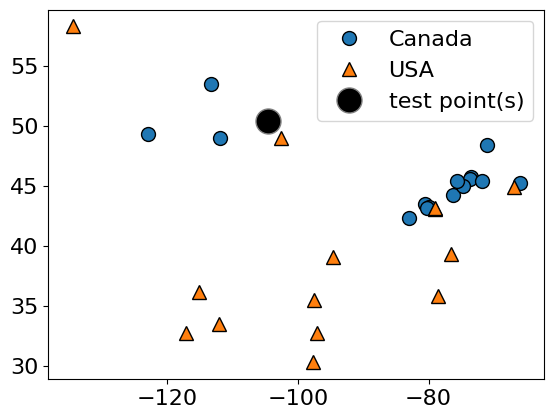

In [22]:
plot_train_test_points(
    X_small_cities,
    y_small_cities,
    test_point,
    class_names=["Canada", "USA"],
    test_format="circle",
)

- Given a new data point, predict the class of the data point by finding the "closest" data point in the training set, i.e., by finding its "nearest neighbour" or majority vote of nearest neighbours. 

Suppose we want to predict the class of the black point.  
- An intuitive way to do this is predict the same label as the "closest" point ($k = 1$) (1-nearest neighbour)
- We would predict a target of **USA** in this case.

n_neighbors 1


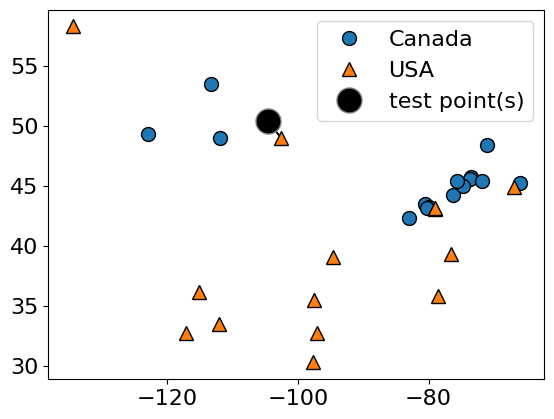

In [23]:
plot_knn_clf(
    X_small_cities,
    y_small_cities,
    test_point,
    n_neighbors=1,
    class_names=["Canada", "USA"],
    test_format="circle",
)

How about using $k > 1$ to get a more robust estimate? 
- For example, we could also use the 3 closest points (*k* = 3) and let them **vote** on the correct class.  
- The **Canada** class would win in this case. 

n_neighbors 3


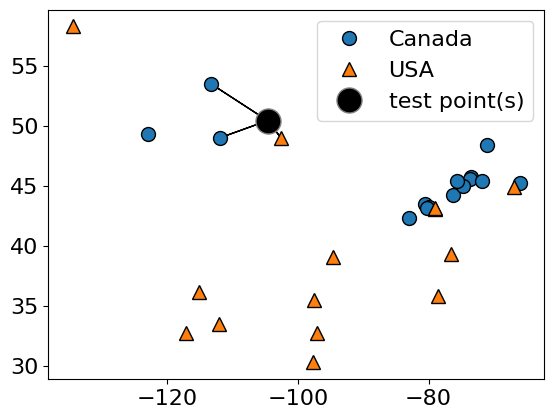

In [24]:
plot_knn_clf(
    X_small_cities,
    y_small_cities,
    test_point,
    n_neighbors=3,
    class_names=["Canada", "USA"],
    test_format="circle",
)

In [25]:
from sklearn.neighbors import KNeighborsClassifier

k_values = [1, 3]

for k in k_values:
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_small_cities, y_small_cities)
    print(
        "Prediction of the black dot with %d neighbours: %s"
        % (k, neigh.predict(test_point))
    )

Prediction of the black dot with 1 neighbours: ['USA']
Prediction of the black dot with 3 neighbours: ['Canada']


<br>

### Choosing `n_neighbors`

- The primary **hyperparameter** of the model is `n_neighbors` ($k$) which decides how many neighbours should vote during prediction? 
- What happens when we play around with `n_neighbors`?
- Are we more likely to overfit with a low `n_neighbors` or a high `n_neighbors`?
- Let's examine the effect of the hyperparameter on our cities data. 

In [26]:
X = cities_df.drop(columns=["country"])
y = cities_df["country"]

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=123
)

In [27]:
k = 1
knn1 = KNeighborsClassifier(n_neighbors=k)
scores = cross_validate(knn1, X_train, y_train, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.003422,0.004302,0.710526,1.0
1,0.002558,0.003743,0.684211,1.0
2,0.002413,0.003247,0.842105,1.0
3,0.001693,0.002559,0.702703,1.0
4,0.001588,0.003471,0.837838,1.0


In [28]:
k = 100
knn100 = KNeighborsClassifier(n_neighbors=k)
scores = cross_validate(knn100, X_train, y_train, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.004033,0.221566,0.605263,0.600000
1,0.002861,0.014070,0.605263,0.600000
2,0.002461,0.005588,0.605263,0.600000
3,0.002659,0.005713,0.594595,0.602649
4,0.002588,0.006432,0.594595,0.602649


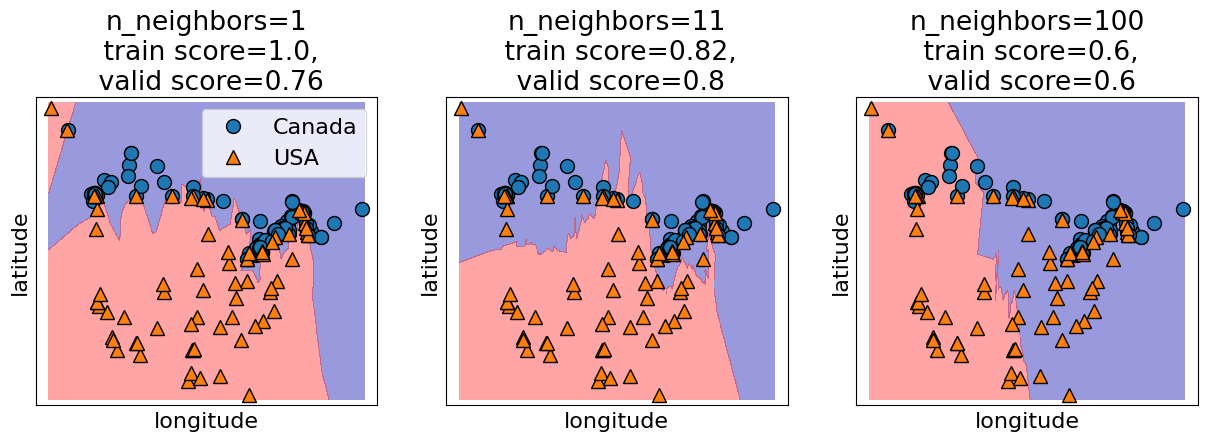

In [29]:
plot_knn_decision_boundaries(X_train, y_train, k_values=[1, 11, 100])

### How to choose `n_neighbors`?

- `n_neighbors` is a hyperparameter
- We can use hyperparameter optimization to choose `n_neighbors`.

In [30]:
results_dict = {
    "n_neighbors": [],
    "mean_train_score": [],
    "mean_cv_score": [],
    "std_cv_score": [],
    "std_train_score": [],
}
param_grid = {"n_neighbors": np.arange(1, 50, 5)}

for k in param_grid["n_neighbors"]:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_validate(knn, X_train, y_train, return_train_score=True)
    results_dict["n_neighbors"].append(k)

    results_dict["mean_cv_score"].append(np.mean(scores["test_score"]))
    results_dict["mean_train_score"].append(np.mean(scores["train_score"]))
    results_dict["std_cv_score"].append(scores["test_score"].std())
    results_dict["std_train_score"].append(scores["train_score"].std())

results_df = pd.DataFrame(results_dict)

In [31]:
results_df = results_df.set_index("n_neighbors")
results_df

,mean_train_score,mean_cv_score,std_cv_score,std_train_score
n_neighbors,,,,
1,1.000000,0.755477,0.069530,0.000000
6,0.831135,0.792603,0.046020,0.013433
11,0.819152,0.802987,0.041129,0.011336
16,0.801863,0.782219,0.074141,0.008735
21,0.777934,0.766430,0.062792,0.016944
26,0.755364,0.723613,0.061937,0.025910
31,0.743391,0.707681,0.057646,0.030408
36,0.728777,0.707681,0.064452,0.021305
41,0.706128,0.681223,0.061241,0.018310


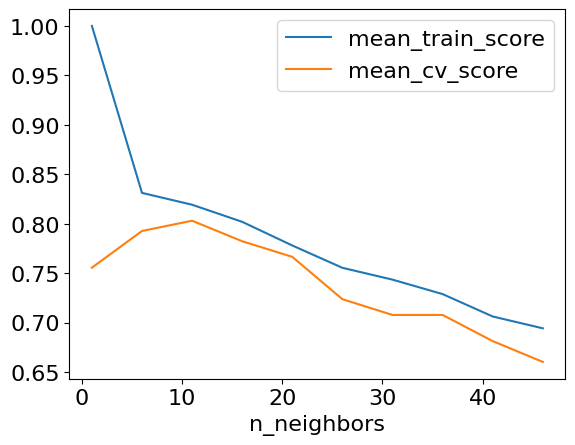

In [32]:
results_df[["mean_train_score", "mean_cv_score"]].plot();

In [33]:
best_n_neighbours = results_df.idxmax()["mean_cv_score"]
best_n_neighbours

np.int64(11)

Let's try our best model on test data. 

In [34]:
knn = KNeighborsClassifier(n_neighbors=best_n_neighbours)
knn.fit(X_train, y_train)
print("Test accuracy: %0.3f" % (knn.score(X_test, y_test)))

Test accuracy: 0.905


Seems like we got lucky with the test set here.

<br><br>

## ❓❓ Questions for you 

### (iClicker) Exercise 4.1 

**Select all of the following statements which are TRUE.**

- (A) Analogy-based models find examples from the test set that are most similar to the query example we are predicting.
- (B) Euclidean distance will always have a non-negative value.
- (C) With $k$-NN, setting the hyperparameter $k$ to larger values typically reduces training error. 
- (D) Similar to decision trees, $k$-NNs finds a small set of good features.
- (E) In $k$-NN, with $k > 1$, the classification of the closest neighbour to the test example always contributes the most to the prediction.

## Break (5 min)

![](../img/eva-coffee.png)


<br><br>

## More on $k$-NNs [[video](https://youtu.be/IRGbqi5S9gQ)]

### Other useful arguments of `KNeighborsClassifier`

- `weights` $\rightarrow$ When predicting label, you can assign higher weight to the examples which are closer to the query example.  
- Exercise for you: Play around with this argument. Do you get a better validation score? 

### Regression with $k$-nearest neighbours ($k$-NNs)

- Can we solve regression problems with $k$-nearest neighbours algorithm? 
- In $k$-NN regression we take the average of the $k$-nearest neighbours. 
- We can also have weighted regression. 

See an example of regression in the lecture notes. 

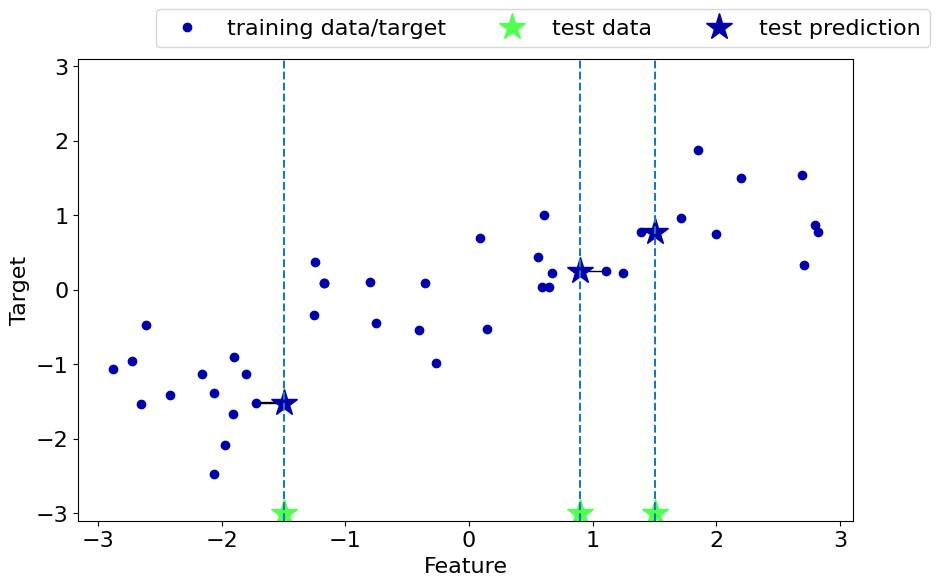

In [35]:
mglearn.plots.plot_knn_regression(n_neighbors=1)

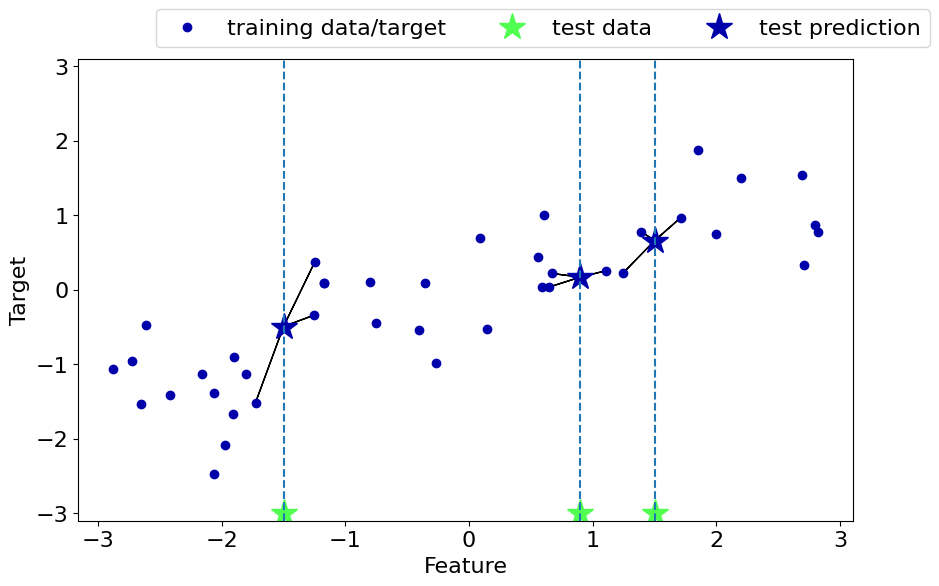

In [36]:
mglearn.plots.plot_knn_regression(n_neighbors=3)

### Pros of $k$-NNs for supervised learning

- Easy to understand, interpret.
- Simple hyperparameter $k$ (`n_neighbors`) controlling the fundamental tradeoff.
- Can learn very complex functions given enough data.
- Lazy learning: Takes no time to `fit`

### Cons of $k$-NNs for supervised learning

- Can be potentially be VERY slow during prediction time, especially when the training set is very large. 
- Often not that great test accuracy compared to the modern approaches.
- It does not work well on datasets with many features or where most feature values are 0 most of the time (sparse datasets).    

___
For regular $k$-NN for supervised learning (not with sparse matrices), you should scale your features. We'll be looking into it soon. 
___

### Curse of dimensionality

- Affects all learners but especially bad for nearest-neighbour. 
- $k$-NN usually works well when the number of dimensions $d$ is small but things fall apart quickly as $d$ goes up.
- If there are **many irrelevant attributes, $k$-NN is hopelessly confused** because all of them contribute to finding similarity between examples. 
- With enough irrelevant attributes the accidental similarity swamps out meaningful similarity and $k$-NN is no better than random guessing.  

In [37]:
from sklearn.datasets import make_classification

nfeats_accuracy = {"nfeats": [], "dummy_valid_accuracy": [], "KNN_valid_accuracy": []}
for n_feats in range(4, 2000, 100):
    X, y = make_classification(n_samples=2000, n_features=n_feats, n_classes=2)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=123
    )
    dummy = DummyClassifier(strategy="most_frequent")
    dummy_scores = cross_validate(dummy, X_train, y_train, return_train_score=True)

    knn = KNeighborsClassifier()
    scores = cross_validate(knn, X_train, y_train, return_train_score=True)
    nfeats_accuracy["nfeats"].append(n_feats)
    nfeats_accuracy["KNN_valid_accuracy"].append(np.mean(scores["test_score"]))
    nfeats_accuracy["dummy_valid_accuracy"].append(np.mean(dummy_scores["test_score"]))

In [38]:
pd.DataFrame(nfeats_accuracy)

,nfeats,dummy_valid_accuracy,KNN_valid_accuracy
0,4,0.501875,0.978750
1,104,0.499375,0.812500
2,204,0.505000,0.729375
3,304,0.505625,0.655625
4,404,0.502500,0.633750
5,504,0.510000,0.702500
6,604,0.502500,0.623750
7,704,0.503125,0.673125
8,804,0.508750,0.610625
9,904,0.499375,0.590625


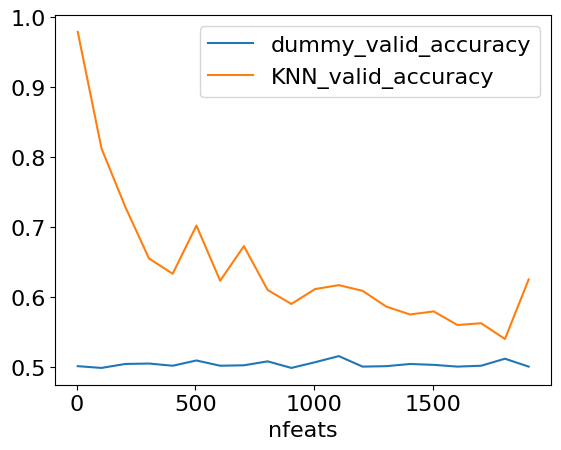

In [39]:
pd.DataFrame(nfeats_accuracy).set_index("nfeats").plot();

### (Optional) Parametric vs non parametric 

- You might see a lot of definitions of these terms.
- A simple way to think about this is: 
    - do you need to store at least $O(n)$ worth of stuff to make predictions? If so, it's non-parametric.
- **Non-parametric example**: $k$-NN is a classic example of non-parametric models.     
- **Parametric example**: decision stump
- If you want to know more about this, find some reading material [here](https://www.cs.ubc.ca/~schmidtm/Courses/340-F16/L6.pdf), [here](http://mlss.tuebingen.mpg.de/2015/slides/ghahramani/gp-neural-nets15.pdf), and [here](https://machinelearningmastery.com/parametric-and-nonparametric-machine-learning-algorithms/). 
- By the way, the terms "parametric" and "non-paramteric" are often used differently by statisticians, see [here](https://help.xlstat.com/s/article/what-is-the-difference-between-a-parametric-and-a-nonparametric-test?language=en_US) for more...



___
$\mathcal{O}(n)$ is referred to as big $\mathcal{O}$ notation. It tells you how fast an algorithm is or how much storage space it requires. For example, in simple terms, if you have $n$ examples and you need to store them all you can say that the algorithm requires $\mathcal{O}(n)$ worth of stuff. 
___

<br><br>

## Support Vector Machines (SVMs) with RBF kernel [[video](https://youtu.be/ic_zqOhi020)]

- Very high-level overview
- Our goals here are
    - Use `scikit-learn`'s SVM model. 
    - Broadly explain the notion of support vectors.  
    - Broadly explain the similarities and differences between $k$-NNs and SVM RBFs.
    - Explain how `C` and `gamma` hyperparameters control the fundamental tradeoff.
    
> (Optional) RBF stands for radial basis functions. We won't go into what it means in this video. Refer to [this video](https://www.youtube.com/watch?v=Qc5IyLW_hns) if you want to know more. 

### Overview

- Another popular similarity-based algorithm is Support Vector Machines with RBF Kernel (SVM RBFs)
- Superficially, SVM RBFs are more like weighted $k$-NNs.
    - The decision boundary is defined by **a set of positive and negative examples** and **their weights** together with **their similarity measure**. 
    - A test example is labeled positive if on average it looks more like positive examples than the negative examples. 

- The **primary difference** between $k$-NNs and SVM RBFs is that 
    - Unlike $k$-NNs, SVM RBFs **only remember the key examples (support vectors)**.
    - SVMs use a different similarity metric which is called a "kernel". A popular kernel is Radial Basis Functions (RBFs)
    - They usually perform better than $k$-NNs! 

### Let's explore SVM RBFs

Let's try SVMs on the cities dataset. 

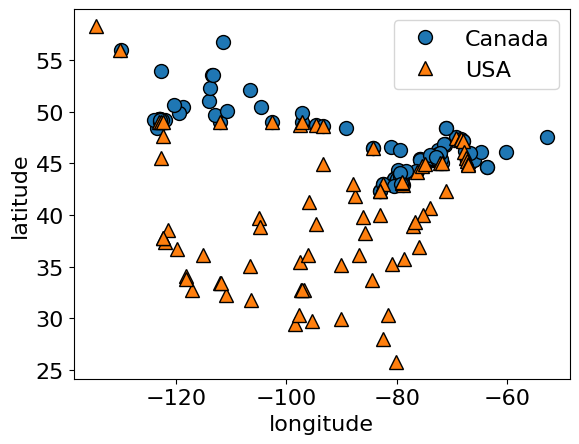

In [40]:
mglearn.discrete_scatter(X_cities.iloc[:, 0], X_cities.iloc[:, 1], y_cities)
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.legend(loc=1);

In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    X_cities, y_cities, test_size=0.2, random_state=123
)

In [42]:
knn = KNeighborsClassifier(n_neighbors=best_n_neighbours)
scores = cross_validate(knn, X_train, y_train, return_train_score=True)
print("Mean validation score %0.3f" % (np.mean(scores["test_score"])))
pd.DataFrame(scores)

Mean validation score 0.803


,fit_time,score_time,test_score,train_score
0,0.003208,0.005164,0.794118,0.819549
1,0.002059,0.003189,0.764706,0.819549
2,0.002328,0.002978,0.727273,0.850746
3,0.001941,0.003623,0.787879,0.828358
4,0.001657,0.003933,0.939394,0.783582


In [43]:
from sklearn.svm import SVC

svm = SVC(gamma=0.01)  # Ignore gamma for now
scores = cross_validate(svm, X_train, y_train, return_train_score=True)
print("Mean validation score %0.3f" % (np.mean(scores["test_score"])))
pd.DataFrame(scores)

Mean validation score 0.820


,fit_time,score_time,test_score,train_score
0,0.007165,0.003048,0.823529,0.842105
1,0.005356,0.002102,0.823529,0.842105
2,0.002462,0.001634,0.727273,0.858209
3,0.002470,0.001626,0.787879,0.843284
4,0.002328,0.001760,0.939394,0.805970


### Decision boundary of SVMs 
- We can think of SVM with RBF kernel as "smooth KNN". 

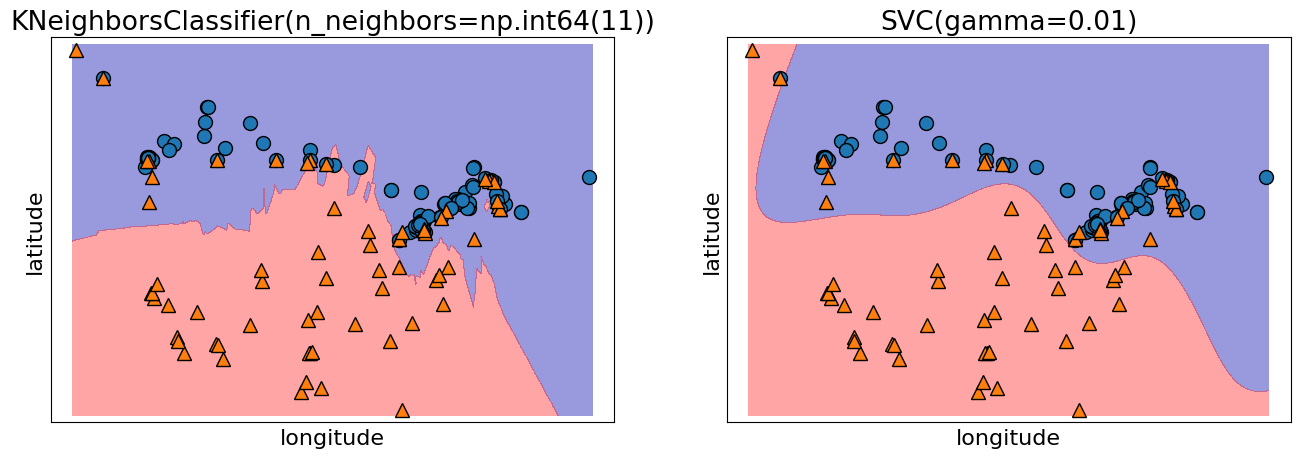

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

for clf, ax in zip([knn, svm], axes):
    clf.fit(X_train, y_train)
    mglearn.plots.plot_2d_separator(
        clf, X_train.to_numpy(), fill=True, eps=0.5, ax=ax, alpha=0.4
    )
    mglearn.discrete_scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], y_train, ax=ax)
    ax.set_title(clf)
    ax.set_xlabel("longitude")
    ax.set_ylabel("latitude")

### Support vectors 

- Each training example either is or isn't a "support vector".
  - This gets decided during `fit`.

- **Main insight: the decision boundary only depends on the support vectors.**

- Let's look at the support vectors in a simpler problem. 

In [45]:
from sklearn.datasets import make_blobs

n = 20
n_classes = 2
X_toy, y_toy = make_blobs(
    n_samples=n, centers=n_classes, random_state=300
)  # Let's generate some fake data

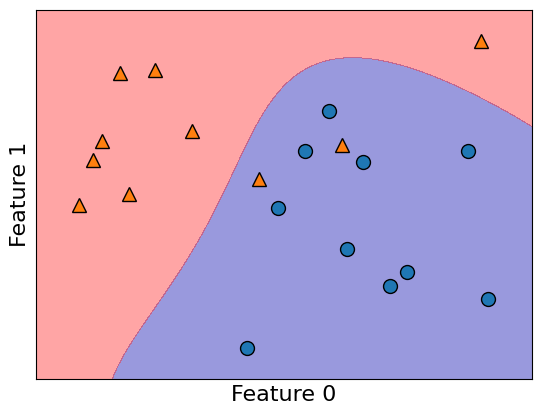

In [46]:
mglearn.discrete_scatter(X_toy[:, 0], X_toy[:, 1], y_toy)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
svm = SVC(kernel="rbf", C=10, gamma=0.1).fit(X_toy, y_toy)
mglearn.plots.plot_2d_separator(svm, X_toy, fill=True, eps=0.5, alpha=0.4)

In [47]:
svm.support_

array([ 3,  8,  9, 14, 19,  1,  4,  6, 17], dtype=int32)

In [48]:
X_toy[svm.support_]

array([[-2.03730912, -7.49852518],
       [-1.10776665, -3.6937689 ],
       [ 0.483923  , -4.33773178],
       [-1.6829074 , -5.24397776],
       [-1.37419828, -4.3357658 ],
       [-1.89963176, -4.78162382],
       [-2.66622445, -4.01676697],
       [ 0.62593608, -2.57502093],
       [-0.96004841, -4.23630586]])

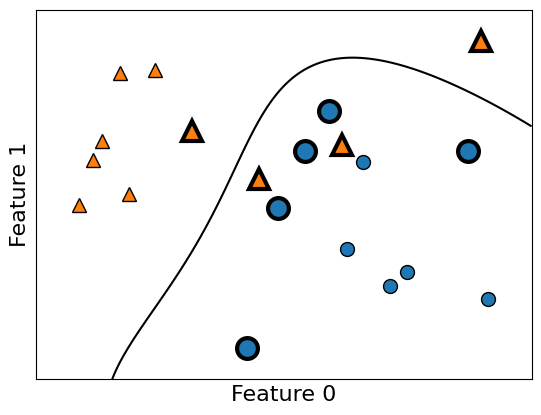

In [49]:
plot_support_vectors(svm, X_toy, y_toy)

The support vectors are the bigger points in the plot above. 

### Hyperparameters of SVM 

- Key hyperparameters of `rbf` SVM are
    - `gamma`
    - `C`
    
- We are not equipped to understand the meaning of these parameters at this point but you are expected to describe **their relation to the fundamental trade-off**.

See [`scikit-learn`'s explanation of RBF SVM parameters](https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html). 

### Relation of `gamma` and the fundamental trade-off

- `gamma` controls the complexity (fundamental trade-off), just like other hyperparameters we've seen.
  - larger `gamma` $\rightarrow$ more complex
  - smaller `gamma` $\rightarrow$ less complex

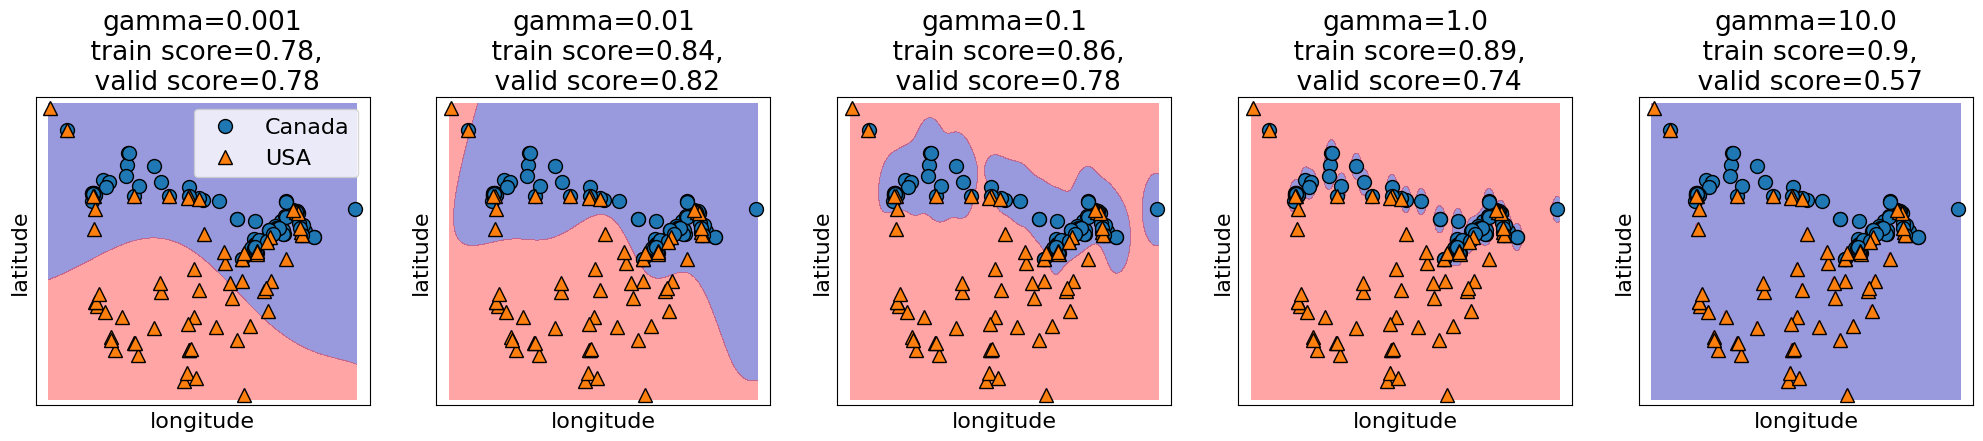

In [50]:
gamma = [0.001, 0.01, 0.1, 1.0, 10.0]
plot_svc_gamma(
    gamma,
    X_train.to_numpy(),
    y_train.to_numpy(),
    x_label="longitude",
    y_label="latitude",
)

### Relation of `C` and the fundamental trade-off

- `C` _also_ affects the fundamental trade-off
    - larger `C` $\rightarrow$ more complex 
    - smaller `C` $\rightarrow$ less complex 

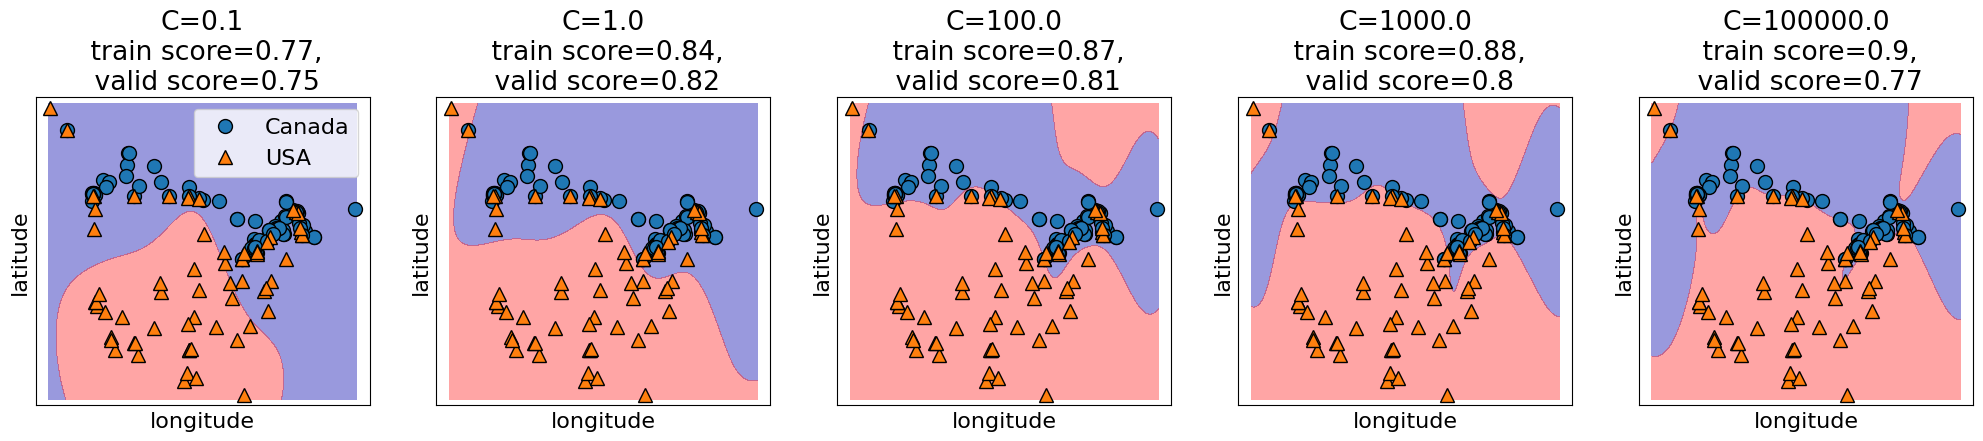

In [51]:
C = [0.1, 1.0, 100.0, 1000.0, 100000.0]
plot_svc_C(
    C, X_train.to_numpy(), y_train.to_numpy(), x_label="longitude", y_label="latitude"
)

### Search over multiple hyperparameters

- So far you have seen how to carry out search over a hyperparameter
- In the above case the best training error is achieved by the most complex model (large `gamma`, large `C`).
- Best validation error requires a hyperparameter search to balance the fundamental tradeoff.
  - In general we can't search them one at a time.
  - More on this next week. But if you cannot wait till then, you may look up the following:
    - [sklearn.model_selection.GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
    - [sklearn.model_selection.RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)

### SVM Regressor

- Similar to KNNs, you can use SVMs for regression problems as well.
- See [`sklearn.svm.SVR`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html) for more details. 

## ❓❓ Questions for you 

## (iClicker) Exercise 4.2 

**Select all of the following statements which are TRUE.**

- (A) $k$-NN may perform poorly in high-dimensional space (say, *d* > 1000). 
- (B) In sklearn’s SVC classifier, large values of gamma tend to result in higher training score but probably lower validation score. 
- (C) If we increase both gamma and C, we can't be certain if the model becomes more complex or less complex.
- (D) As complexity increases, the number of support vectors also increases.
- (E) A k-NN classifier has faster training time but a SVC classifier has (usually) faster prediction time.

<br><br>

### Playground (in tutorial)

In this interactive playground, you will investigate how various algorithms create decision boundaries to distinguish between Iris flower species using their sepal length and width as features. By adjusting the parameters, you can observe how the decision boundaries change, which can result in either overfitting (where the model fits the training data too closely) or underfitting (where the model is too simplistic).

- With **k-Nearest Neighbours ($k$-NN)**, you'll determine how many neighboring flowers to consult. Should we rely on a single nearest neighbor? Or should we consider a wider group? 

- With **Support Vector Machine (SVM)** using the RBF kernel, you'll tweak the hyperparameters `C` and `gamma` to explore the tightrope walk between overly complex boundaries (that might overfit) and overly broad ones (that might underfit).
  
- With **Decision trees**, you'll observe the effect of `max_depth` on the decision boundary. 

Observe the process of crafting and refining decision boundaries, one parameter at a time! Be sure to take breaks to reflect on the results you are observing. 

Column
    [0] Row
        [0] FloatSlider(end=5, name='C (log scale)', start=1, value=1.0)
        [1] IntSlider(end=40, name='n_neighbors', start=1, value=5)
    [1] Row
        [0] FloatSlider(end=5, name='Gamma (log scale)', start=-3, value=1.0)
        [1] IntSlider(end=20, name='max_depth', start=1, value=3)
    [2] ParamFunction(function, _pane=Matplotlib, defer_load=False)
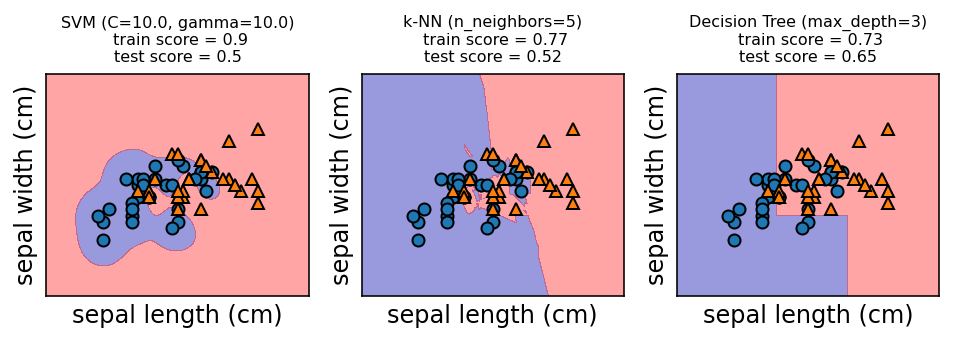

In [52]:
from matplotlib.figure import Figure

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from ipywidgets import interact, FloatLogSlider, IntSlider
import mglearn


# Load dataset and preprocessing
iris = load_iris(as_frame=True)
iris_df = iris.data
iris_df['species'] = iris.target
iris_df = iris_df[iris_df['species'] > 0]
X, y = iris_df[['sepal length (cm)', 'sepal width (cm)']], iris_df['species']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=123)


# Common plot settings
def plot_results(model, X_train, y_train, title, ax):
    mglearn.plots.plot_2d_separator(model, X_train.values, fill=True, alpha=0.4, ax=ax);
    mglearn.discrete_scatter(
        X_train["sepal length (cm)"], X_train["sepal width (cm)"], y_train, s=6, ax=ax
    );
    ax.set_xlabel("sepal length (cm)", fontsize=12);
    ax.set_ylabel("sepal width (cm)", fontsize=12);
    train_score = np.round(model.score(X_train.values, y_train), 2)
    test_score = np.round(model.score(X_test.values, y_test), 2)
    ax.set_title(
        f"{title}\n train score = {train_score}\ntest score = {test_score}", fontsize=8
    );
    pass


# Widgets for SVM, k-NN, and Decision Tree
c_widget = pn.widgets.FloatSlider(
    value=1.0, start=1, end=5, step=0.1, name="C (log scale)"
)
gamma_widget = pn.widgets.FloatSlider(
    value=1.0, start=-3, end=5, step=0.1, name="Gamma (log scale)"
)
n_neighbors_widget = pn.widgets.IntSlider(
    start=1, end=40, step=1, value=5, name="n_neighbors"
)
max_depth_widget = pn.widgets.IntSlider(
    start=1, end=20, step=1, value=3, name="max_depth"
)


# The update function to create the plots
def update_plots(c, gamma=1.0, n_neighbors=5, max_depth=3):
    c_log = round(10**c, 2)  # Transform C to logarithmic scale
    gamma_log = round(10**gamma, 2)   # Transform Gamma to logarithmic scale

    fig = Figure(figsize=(8, 2))
    axes = fig.subplots(1, 3)

    models = [
        SVC(C=c_log, gamma=gamma_log, random_state=42),
        KNeighborsClassifier(n_neighbors=n_neighbors),
        DecisionTreeClassifier(max_depth=max_depth, random_state=42),
    ]
    titles = [
        f"SVM (C={c_log}, gamma={gamma_log})",
        f"k-NN (n_neighbors={n_neighbors})",
        f"Decision Tree (max_depth={max_depth})",
    ]
    for model, title, ax in zip(models, titles, axes):
        model.fit(X_train.values, y_train)
        plot_results(model, X_train, y_train, title, ax);
    # print(c, gamma, n_neighbors, max_depth)
    return pn.pane.Matplotlib(fig, tight=True);


# Bind the function to the panel widgets
interactive_plot = pn.bind(
    update_plots,
    c=c_widget.param.value_throttled,
    gamma=gamma_widget.param.value_throttled,
    n_neighbors=n_neighbors_widget.param.value_throttled,
    max_depth=max_depth_widget.param.value_throttled,
)

# Layout the widgets and the plot
dashboard = pn.Column(
    pn.Row(c_widget, n_neighbors_widget),
    pn.Row(gamma_widget, max_depth_widget),
    interactive_plot,
)

# Display the interactive dashboard
dashboard

<br><br><br><br>

## Summary

- We have KNNs and SVMs as new supervised learning techniques in our toolbox.
- These are analogy-based learners and the idea is to assign nearby points the same label.
- Unlike decision trees, all features are equally important. 
- Both can be used for classification or regression (much like the other methods we've seen).

### Coming up:

- Are we ready to do machine learning on real-world datasets?
- What happens if we have missing values in our data? 
- What do we do if we have features with categories or string values?


![](../img/eva-seeyou.png)